In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import cv2
import shutil
from PIL import Image
import time
import csv
import threading

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
# Import mediapipe
import mediapipe as mp
# from mediapipe.solutions.drawing_utils import mp_drawing
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

In [ ]:
# Define parameters
selected_word = ["Do","Vang","Xanh la","Xanh duong","Hong"]
n_classes = len(selected_word)
# Frame sampling parameters
frames_per_video = 10
target_size = (1920, 1080)

# Dataset multiplier
number_of_augmentations = 10

# some global params
SIZE = (128, 128)

# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 100
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'

# Load data - Data preprocessing

## Function

In [3]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

In [ ]:
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

In [ ]:
def readFramesThread(sema, x_data, y_data, word, path, dsize):
  sema.acquire()

  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = preprocessingImg(img, dsize)
    lframes.append(img)

  x_data.append(lframes) # add video into list
  y_data.append(word) # add label

  # time.sleep(0.2)
  sema.release()


def readDataThread(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  maxthreads = NUM_THREADS
  sema = threading.Semaphore(value=maxthreads) # sema type
  threads = list()

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    print(reader)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]

      if (listWord != None) and (word not in listWord): # decrease num classes
        continue

      # print(video)
      path = os.path.join(input_path, video)
      # execute thread
      thread = threading.Thread( target=readFramesThread, args=(sema, x_data, y_data, word, path, dsize) )
      threads.append(thread)
      thread.start()

    for t in threads: # for waiting all thread end
      t.join()

  return x_data, y_data


In [ ]:
def readFrames(path, dsize):
  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = resizeImage(img, dsize)
    lframes.append(img)

  return lframes

def readData(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]
      # if (listWord != None) and (word not in listWord): # decrease num classes
      #   continue

      print(video)
      path = os.path.join(input_path, video)
      lframes = readFrames(path, dsize)

      x_data.append(lframes) # add video into list
      y_data.append(word) # add label

  return x_data, y_data

In [ ]:

#encoder label to train in model
def encoderLabel(y_train, y_test, classes_file = 'classes.npy', save = True):
  encoder = LabelEncoder()
  encoder.fit(y_train)

  # save classes, save as numpy array
  if save == True:
    np.save(classes_file, encoder.classes_)

  # encoder to number
  y_train1 = encoder.fit_transform(y_train)
  y_test1 = encoder.fit_transform(y_test)
  # [a,c, y,a ] -> [1,2,3,1]
  num_classes=len(np.unique(y_train))
  #encoder to binary matrix
  y_train2 = to_categorical(y_train1, num_classes=len(np.unique(y_train)))
  y_test2 = to_categorical(y_test1, num_classes=len(np.unique(y_test)))

  return y_train2, y_test2, num_classes

##  Main

In [ ]:
# prepare train data
start = time.time()

train_path = "/content/drive/MyDrive/VietNam SignLanguage/Data_Aug_3/train_dir_2"
train_csv = '/content/drive/MyDrive/VietNam SignLanguage/Data_Aug_3/train_dir_2_new.csv'

# x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE, listWord)
x_o, y_o = readDataThread(train_path, train_csv, SIZE)
end = time.time()
print('time:', end - start)

time: 332.74647974967957


In [ ]:
X_train,X_val,y_train,y_val = train_test_split(x_o,y_o, test_size=0.3)

 # Mediapipe holistic

In [ ]:
# Mediapipe holistic
mp_holistic = mp.solutions.holistic

def detect_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=False) as holistic:
        results = holistic.process(frame_rgb)
    return results

In [ ]:
# right hand
def get_coord_for_R_hand(results):
    x_coord_R_hand = []
    y_coord_R_hand = []
    z_coord_R_hand = []

    if results.right_hand_landmarks:
        #append coordinates
        for landmark in results.right_hand_landmarks.landmark:
            if landmark:
                x_coord_R_hand.append(landmark.x)
                y_coord_R_hand.append(landmark.y)
                z_coord_R_hand.append(landmark.z)
            else:
                x_coord_R_hand.append(0)
                y_coord_R_hand.append(0)
                z_coord_R_hand.append(0)
        print("✅ Right hand detected")

    else:
        for index in range(21):
            x_coord_R_hand.append(0)
            y_coord_R_hand.append(0)
            z_coord_R_hand.append(0)
        print("❌ Right hand not detected")

    return x_coord_R_hand, y_coord_R_hand, z_coord_R_hand

In [ ]:
#left hand

def get_coord_for_L_hand(results):
    x_coord_L_hand = []
    y_coord_L_hand = []
    z_coord_L_hand = []

    if results.left_hand_landmarks:
        # Append coordinates
        for landmark in results.left_hand_landmarks.landmark:
            if landmark:
                x_coord_L_hand.append(landmark.x)
                y_coord_L_hand.append(landmark.y)
                z_coord_L_hand.append(landmark.z)
            else:
                x_coord_L_hand.append(0)
                y_coord_L_hand.append(0)
                z_coord_L_hand.append(0)
        print("✅ Left hand detected")
    else:
        # No left hand detected, populate with NaN values
        for index in range(21):
            x_coord_L_hand.append(0)
            y_coord_L_hand.append(0)
            z_coord_L_hand.append(0)
        print("❌ Left hand not detected")

    return x_coord_L_hand, y_coord_L_hand, z_coord_L_hand

In [ ]:
# pose
def get_coord_for_pose(results):
    x_coord_pose = []
    y_coord_pose = []
    z_coord_pose = []

    if results.pose_landmarks:
        # loop over all landmarks for each hand
        for landmark in results.pose_landmarks.landmark:
            if landmark:
                x_coord_pose.append(landmark.x)
                y_coord_pose.append(landmark.y)
                z_coord_pose.append(landmark.z)
                # print(f"Landmark X: {landmark.x}, Y: {landmark.y}, Z: {landmark.z}")
            else:
                x_coord_pose.append(0)
                y_coord_pose.append(0)
                z_coord_pose.append(0)
        print("✅ Pose detected")

    else:
        x_coord_pose = [0] * 33
        y_coord_pose = [0] * 33
        z_coord_pose = [0] * 33
        print("❌ Pose not detected")

    x_coord_pose = x_coord_pose[0:25]
    y_coord_pose = y_coord_pose[0:25]
    z_coord_pose = z_coord_pose[0:25]

    return x_coord_pose, y_coord_pose, z_coord_pose

In [ ]:
#normalize coordinates with respect to the nose
def get_norm_coord(x, y, z, results):
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    x_norm = []
    y_norm = []
    z_norm = []

    for coord_x, coord_y, coord_z in zip(x, y, z):
        if all(coord == 0 for coord in (coord_x, coord_y, coord_z)):
            x_norm.append(0)
            y_norm.append(0)
            z_norm.append(0)
        else:
            x_norm.append((coord_x - x_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))
            y_norm.append((coord_y - y_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))
            z_norm.append((coord_z - z_coord_pose[0])/(abs(x_coord_pose[11]-x_coord_pose[12])))

    return x_norm, y_norm, z_norm

In [ ]:
#daw the annoted image

def draw_(results, frame):
    annotated_image = frame.copy()

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Right hand annotated")
    else:
        print("❌ Right hand not annotated")

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS)
        print("✅ Left hand annotated")
    else:
        print("❌ Left hand not annotated")


    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.pose_landmarks,
            connections=mp_holistic.POSE_CONNECTIONS)
        print("✅ Pose annotated")
    else:
        print("❌ Pose not annotated")

    return annotated_image

In [ ]:
# get a series of coordinates for one frame
def coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    X_frame = x_coord_R_hand + y_coord_R_hand + z_coord_R_hand + \
          x_coord_L_hand + y_coord_L_hand + z_coord_L_hand + \
          x_coord_pose + y_coord_pose + z_coord_pose
    return X_frame

In [ ]:
# get a series of coordinates for one frame
def normalized_coordinates_per_frame(results):
    x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
    x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
    x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

    x_norm_coord_R_hand, y_norm_coord_R_hand, z_norm_coord_R_hand  = get_norm_coord(x_coord_R_hand, y_coord_R_hand, z_coord_R_hand, results)
    x_norm_coord_L_hand, y_norm_coord_L_hand, z_norm_coord_L_hand = get_norm_coord(x_coord_L_hand, y_coord_L_hand, z_coord_L_hand, results)
    x_norm_coord_pose, y_norm_coord_pose, z_norm_coord_pose = get_norm_coord(x_coord_pose, y_coord_pose, z_coord_pose, results)

    X_frame_norm = x_norm_coord_R_hand + y_norm_coord_R_hand + z_norm_coord_R_hand + \
          x_norm_coord_L_hand + y_norm_coord_L_hand + z_norm_coord_L_hand + \
          x_norm_coord_pose + y_norm_coord_pose + z_norm_coord_pose
    return X_frame_norm

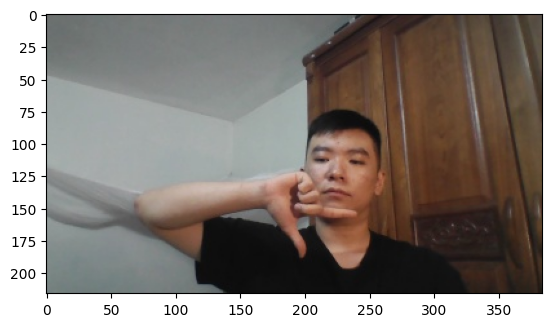

In [ ]:
frame = cv2.imread("/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir/Do/Do_011_001.mp4/Do_011_001_frame_10.jpeg")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.show()

In [ ]:
results = detect_landmarks(frame_rgb)
x_coord_R_hand, y_coord_R_hand, z_coord_R_hand = get_coord_for_R_hand(results)
x_coord_L_hand, y_coord_L_hand, z_coord_L_hand = get_coord_for_L_hand(results)
x_coord_pose, y_coord_pose, z_coord_pose = get_coord_for_pose(results)

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected


✅ Right hand annotated
❌ Left hand not annotated
✅ Pose annotated


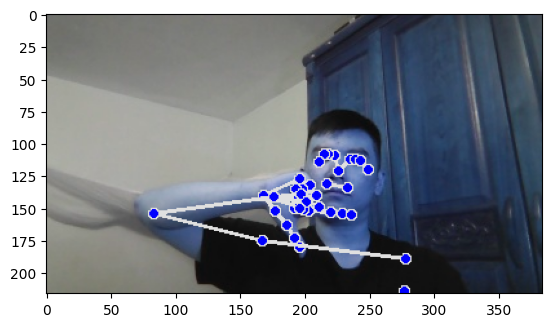

In [ ]:
annotated_image = draw_(results, frame)
plt.imshow(annotated_image)

In [ ]:
print(len(x_coord_R_hand))
print(len(y_coord_R_hand))
print(len(z_coord_R_hand))
print(len(x_coord_L_hand))
print(len(y_coord_L_hand))
print(len(z_coord_L_hand))
print(len(x_coord_pose))
print(len(y_coord_pose))
print(len(z_coord_pose))

21
21
21
21
21
21
25
25
25


In [ ]:
X_frame = normalized_coordinates_per_frame(results)
len(X_frame)

✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected


201

In [ ]:
# Apply mediapipe for all frames
def mediapipe_video_to_coord(X):
    X_coord = []

    for video_count in range(len(X)):
        video = X[video_count]
        video_frames = []

        for frame_count in range(NBFRAME):
            frame = video[frame_count]
            results = detect_landmarks(frame)
            # X_frame = coordinates_per_frame(results)
            X_frame = normalized_coordinates_per_frame(results)
            video_frames.append(X_frame)

        X_coord.append(video_frames)

    X_coord = tf.convert_to_tensor(X_coord)
    return X_coord
# def mediapipe_video_to_coord(video_folder):
#     X_coord = []

#     # List all files in the video folder
#     video_files = os.listdir(video_folder)
#     video_files.sort()  # Ensure files are sorted

#     for video_file in video_files:
#         video_frames = []
#         video_path = os.path.join(video_folder, video_file)

#         # List all frames in the video folder
#         frame_files = os.listdir(video_folder)
#         frame_files.sort()  # Ensure files are sorted
#         print(frame_files)
#         for frame_file in frame_files:
#             frame_path = os.path.join(video_folder, frame_file)

#             # Read frame using OpenCV
#             frame = cv2.imread(frame_path)

#             # Process frame (example: detect landmarks)
#             results = detect_landmarks(frame)
#             # X_frame = coordinates_per_frame(results)
#             X_frame = normalized_coordinates_per_frame(results)

#             video_frames.append(X_frame)

#         X_coord.append(video_frames)

#     X_coord = tf.convert_to_tensor(X_coord)
#     return X_coord

In [ ]:
X_aug_coord = mediapipe_video_to_coord("/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/train_dir/Do/")
X_aug_coord.shape

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
print(_val)

['Xanh la', 'Vang', 'Vang', 'Xanh duong', 'Xanh la', 'Xanh la', 'Xanh duong', 'Vang', 'Xanh duong', 'Do', 'Xanh la', 'Xanh duong', 'Xanh duong', 'Xanh duong', 'Hong', 'Hong', 'Xanh duong', 'Do', 'Xanh la', 'Xanh duong', 'Hong', 'Xanh la', 'Do', 'Hong', 'Xanh la', 'Hong', 'Vang', 'Vang', 'Xanh duong', 'Vang', 'Hong', 'Xanh la', 'Hong', 'Do', 'Xanh duong', 'Xanh la', 'Do', 'Vang', 'Hong', 'Vang', 'Xanh la', 'Xanh duong', 'Xanh la', 'Hong', 'Do', 'Hong', 'Xanh duong', 'Vang', 'Hong', 'Xanh la', 'Do', 'Do', 'Xanh la', 'Vang', 'Do', 'Hong', 'Xanh duong', 'Xanh duong', 'Hong', 'Xanh duong', 'Hong', 'Xanh la', 'Do', 'Xanh duong', 'Xanh la', 'Do', 'Vang', 'Hong', 'Do', 'Do', 'Xanh duong', 'Xanh duong', 'Vang', 'Xanh la', 'Do', 'Xanh la', 'Do', 'Do', 'Vang', 'Hong', 'Xanh la', 'Xanh la', 'Do', 'Xanh duong', 'Xanh duong', 'Hong', 'Do', 'Hong', 'Hong', 'Xanh la', 'Xanh la', 'Xanh la', 'Hong', 'Vang', 'Xanh la', 'Xanh la', 'Xanh la', 'Xanh la', 'Do', 'Do', 'Vang', 'Hong', 'Xanh duong', 'Do', 'Xanh

In [ ]:
# convert to numpy array
x_train = mediapipe_video_to_coord(np.array(X_train))
x_val = mediapipe_video_to_coord(np.array(X_val))
y_train = np.array(y_train)
y_val = np.array(y_val)
print('x_train shape', x_train.shape) # (400, 10, 128, 128, 3) max 2560
print('y_train shape', y_train.shape) # (400,)
print('x_test shape', x_val.shape) # (100, 10, 128, 128, 3) max 640
print('y_test shape', y_val.shape) # (100,)

convert = False
if convert == True:
  n, nb, h, w, c = x_train.shape
  x_train= x_train.reshape(n, nb, h*w*c)
  n, nb, h, w, c = x_val.shape
  x_test= x_val.reshape(n, nb, h*w*c)

  print('x_train shape', x_train.shape) # (400, 10, 223) max 2560
  print('y_train shape', y_train.shape) # (400,)
  print('x_test shape', x_val.shape) # (100, 10, 128, 128, 3) max 640
  print('y_test shape', y_val.shape) # (100,)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Right hand detected
❌ Left hand not detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
❌ Right hand not detected
✅ Left hand detected
✅ Pose detected
✅ Pose detected
✅ Pose detected
✅ Pose 

In [ ]:
x_train = x_train /255.
x_val = x_val / 255.

<h1> Encode label </h1>

In [ ]:
# show num classes, it is neccesảy to run
listclasses =  np.unique(y_train)
num_classes = len(listclasses)
print(num_classes)
print(listclasses)
# encode label for training
y_train_decode, y_val_decode, num_classes = encoderLabel(y_train, y_val)
# y_train_decode, y_test_decode are var which encode for training
# y_train, y_test are original var to test after that, for showing word from predicted video
print(y_train_decode.shape)
print(y_val_decode.shape)

5
['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
(700, 5)
(300, 5)


# Deployment of LSTM model

In [ ]:
# Model LSTM
dim = 201
def LSTMModel(dim):
    model = Sequential()
    model.add(LSTM(64,return_sequences=True, activation='relu', input_shape=(NBFRAME,dim)))
    model.add(LSTM(128,return_sequences=True, activation = 'relu'))
    model.add(LSTM(256,return_sequences=True,activation="relu"))
    model.add(LSTM(64, return_sequences = False,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(5,activation='softmax'))
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
    model.compile(optimizer = 'Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    return model


In [ ]:
model = LSTMModel(dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            68096     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           394240    
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [ ]:
tic = time.time()

EPOCHS = 100
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_val, y_val_decode),
            verbose=1,
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/100
35/35 [==============================] - 9s 107ms/step - loss: 1.6105 - categorical_accuracy: 0.1800 - val_loss: 1.6096 - val_categorical_accuracy: 0.2300
Epoch 2/100
35/35 [==============================] - 2s 61ms/step - loss: 1.5993 - categorical_accuracy: 0.2000 - val_loss: 1.5106 - val_categorical_accuracy: 0.1833
Epoch 3/100
35/35 [==============================] - 2s 69ms/step - loss: 1.2448 - categorical_accuracy: 0.3714 - val_loss: 1.0685 - val_categorical_accuracy: 0.4267
Epoch 4/100
35/35 [==============================] - 2s 65ms/step - loss: 1.0050 - categorical_accuracy: 0.4686 - val_loss: 0.9917 - val_categorical_accuracy: 0.4300
Epoch 5/100
35/35 [==============================] - 3s 99ms/step - loss: 0.9955 - categorical_accuracy: 0.4943 - val_loss: 0.9701 - val_categorical_accuracy: 0.5067
Epoch 6/100
35/35 [==============================] - 3s 80ms/step - loss: 0.8784 - categorical_accuracy: 0.5500 - val_loss: 1.1957 - val_categorical_accuracy: 0.4667
Epo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


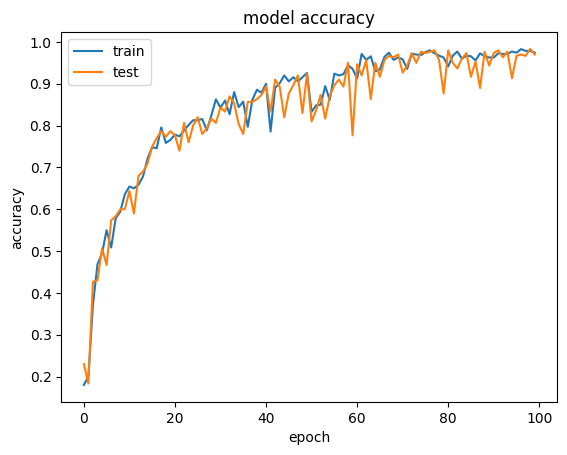

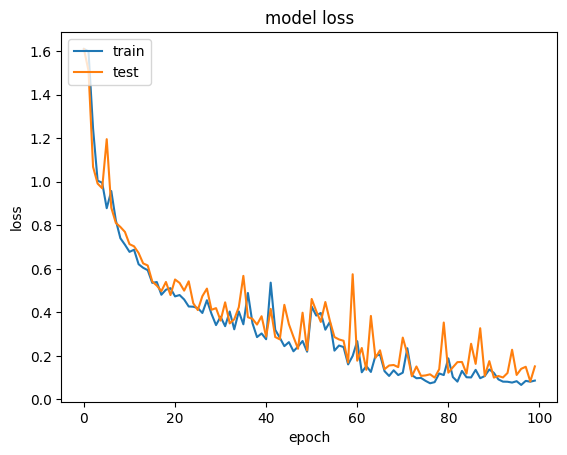

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-Mediapipe_Aug.keras")

In [ ]:
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Sử dụng axis=1 thay vì axis=3
y_true_classes = np.argmax(y_val_decode, axis=1)  # Sử dụng axis=0 để chuyển đổi thành dạng số lớp

from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


10/10 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        55
           1       0.99      0.96      0.97        69
           2       0.96      0.97      0.96        67
           3       0.98      1.00      0.99        56
           4       0.93      1.00      0.96        53

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



#  Evaluation on test folder

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(selected_word[np.argmax(res)])
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if selected_word[np.argmax(res)] != sentence[-1]:
                            sentence.append(selected_word[np.argmax(res)])
                    else:
                        sentence.append(selected_word[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, selected_word, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()